# Plot cellprofiler results - area, intensity, major axis and minor axis

In [1]:
import os
import glob
import sys
from pathlib import Path 
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import tifffile
import skimage.exposure as ske
import cv2
import seaborn as sns
from tqdm.notebook import tqdm, trange
import pickle
import pandas as pd

%matplotlib inline
%gui qt5

In [2]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
os.chdir('..')
os.chdir('./src')

In [4]:
from config import *
# import cellprof as cp

In [5]:
cell_type_label = ['BM', 'BM', 'BM', 'BM', 'BM', 'BM', 'BM', 'UC', 'UC', 'UC', 'UC', 'UC', 'UC', 'UC']

In [6]:
list_pair_modif = ['DAPI', 'Nucleolin', 'ATF6', 'GOLPH4', 'TOM20']

In [7]:
# Figures location    
save_path = f"{data_figure}/morphology/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

### Heatmap of area

In [8]:
# cells = cp.Cells.fromDir(data_cp)
# df = cells.getFeatureDataFrame(featurematchers="AreaShape_Area").sort_index()

In [9]:
# import data from CSV - edits NZ
featureSelect = 'AreaShape_Area'

os.chdir(data_cp)
csvFiles = [f for f in os.listdir() if f.endswith('.csv') \
           and 'Experiment' not in f and 'Image' not in f and 'UC' not in f]

df = pd.DataFrame(columns = ['Cell'])
for ii, fileName in enumerate(tqdm(csvFiles)): # each marker and cell type
    
    cellType, marker, _ = fileName.split('_')
    marker = marker.upper()
    dfMarker = pd.read_csv(fileName)
    
    cellLabel = cellType + dfMarker['ImageNumber'].astype(str)
    
    # reformat
    dfSub = pd.DataFrame()
    dfSub['Cell'] = cellLabel
    dfSub[marker] = dfMarker[featureSelect]
    # dfSub['Marker'] = marker
    # df = pd.concat([df, dfSub])
    
    # read UC file too
    fileName = fileName.replace('BM', 'UC')
    dfMarker = pd.read_csv(fileName)
    cellType, marker, _ = fileName.split('_')
    marker = marker.upper()
    cellLabel = cellType + dfMarker['ImageNumber'].astype(str)
    dfSub = pd.concat([dfSub, \
                       pd.DataFrame({'Cell': cellLabel, marker: dfMarker[featureSelect]})])
    
    df = df.merge(dfSub, how = 'outer')
 
df = df.drop_duplicates(subset = ['Cell']).reset_index(drop = True)

  0%|          | 0/11 [00:00<?, ?it/s]

In [10]:
df = df.rename(columns={"BT": "BetaTubulin", "CONA": "ConcanavalinA", "G4": "GOLPH4", "NUC": "Nucleolin", "PH": "Phalloidin", "SOR": "Sortilin", "T20": "TOM20"})
df

,Cell,ATF6,BetaTubulin,ConcanavalinA,DAPI,GOLPH4,HSP60,Nucleolin,Phalloidin,Sortilin,TOM20,WGA
0,BM1,72077,110718,74479,18000,73537,106731,2158,116287,61584,88060,90379
1,BM2,53496,43207,58762,16198,44528,47291,1765,55108,35704,49251,50818
2,BM3,26147,29110,30292,10203,29841,43028,2572,36672,31165,28398,34451
3,BM4,92562,137453,147074,21401,86267,133622,1027,266663,88538,160884,138099
4,BM5,91513,118420,103561,26186,50304,92454,2498,174239,76510,173177,96925
5,BM6,137280,162026,167414,21884,127784,231791,887,229626,180883,185333,231986
6,BM7,79126,177176,118167,24240,89119,156379,707,289824,52895,137833,134474
7,UC1,95622,198615,119233,25724,105132,247370,10989,145333,178156,122737,130533
8,UC2,64911,148244,88994,23470,75821,125875,9814,71630,89586,75906,83281
9,UC3,64766,154339,105803,24846,69107,152705,3180,76489,70557,101154,83649


  0%|          | 0/1 [00:00<?, ?it/s]

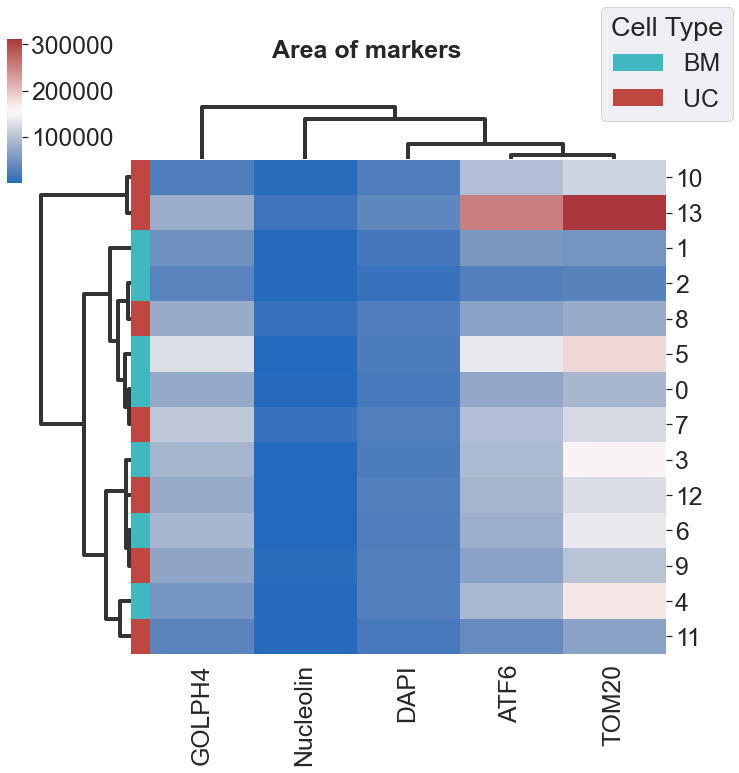

In [11]:
metric_list = [
    'correlation',
]

data_pivot = df
data_pivot = data_pivot.loc[:, list_pair_modif]

lut1 = dict(zip(set(cell_type_label), sns.hls_palette(len(set(cell_type_label)), l=0.5, s=0.5)))
row_colors1 = pd.Series(cell_type_label).map(lut1)

for metric_temp in tqdm(metric_list):
    sns.set(font_scale = 2.25)
    g=sns.clustermap(data_pivot, 
                     figsize=(10, 10),
                     row_colors=[row_colors1], 
                     yticklabels=True, 
                     cbar_pos=(0, 0.85, 0.02, .2),  
                     metric=metric_temp,
                     dendrogram_ratio=(0.15, 0.1),
                    cmap='vlag', \
                    tree_kws=dict(linewidths=4))

    for label in np.unique(np.array(cell_type_label, dtype=object)):
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cell Type', loc="upper left", bbox_to_anchor=(0.85, 3))
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 

    g.fig.suptitle(f"Area of markers", x=0.5, y=1.05, fontsize=25, fontweight='bold')
    image_path_png = save_path+"/area_clustered_"+str(metric_temp)+".png"
    g.savefig(image_path_png, bbox_inches="tight")
    plt.show()

In [12]:
df.set_index('Cell')

,ATF6,BetaTubulin,ConcanavalinA,DAPI,GOLPH4,HSP60,Nucleolin,Phalloidin,Sortilin,TOM20,WGA
Cell,,,,,,,,,,,
BM1,72077,110718,74479,18000,73537,106731,2158,116287,61584,88060,90379
BM2,53496,43207,58762,16198,44528,47291,1765,55108,35704,49251,50818
BM3,26147,29110,30292,10203,29841,43028,2572,36672,31165,28398,34451
BM4,92562,137453,147074,21401,86267,133622,1027,266663,88538,160884,138099
BM5,91513,118420,103561,26186,50304,92454,2498,174239,76510,173177,96925
BM6,137280,162026,167414,21884,127784,231791,887,229626,180883,185333,231986
BM7,79126,177176,118167,24240,89119,156379,707,289824,52895,137833,134474
UC1,95622,198615,119233,25724,105132,247370,10989,145333,178156,122737,130533
UC2,64911,148244,88994,23470,75821,125875,9814,71630,89586,75906,83281


In [13]:
# format table for suppl
# BM
tbl = df.set_index('Cell')
tbl.index.name = 'Marker Pair'
tbl = tbl.iloc[:7, :].transpose()
tbl.to_csv(os.path.join(save_path, 'area_BM_table.csv'))

# UC
tbl = df.set_index('Cell')
tbl.index.name = 'Marker Pair'
tbl = tbl.iloc[7:, :].transpose()
tbl.to_csv(os.path.join(save_path, 'area_UC_table.csv'))


### Heatmap of minor axis

In [14]:
# import data from CSV
featureSelect = 'AreaShape_MinorAxisLength'

os.chdir(data_cp)
csvFiles = [f for f in os.listdir() if f.endswith('.csv') \
           and 'Experiment' not in f and 'Image' not in f and 'UC' not in f]

df2 = pd.DataFrame(columns = ['Cell'])
for ii, fileName in enumerate(tqdm(csvFiles)): # each marker and cell type
    
    cellType, marker, _ = fileName.split('_')
    marker = marker.upper()
    dfMarker = pd.read_csv(fileName)
    
    cellLabel = cellType + dfMarker['ImageNumber'].astype(str)
    
    # reformat
    dfSub = pd.DataFrame()
    dfSub['Cell'] = cellLabel
    dfSub[marker] = dfMarker[featureSelect]
    # dfSub['Marker'] = marker
    # df = pd.concat([df, dfSub])
    
    # read UC file too
    fileName = fileName.replace('BM', 'UC')
    dfMarker = pd.read_csv(fileName)
    cellType, marker, _ = fileName.split('_')
    marker = marker.upper()
    cellLabel = cellType + dfMarker['ImageNumber'].astype(str)
    dfSub = pd.concat([dfSub, \
                       pd.DataFrame({'Cell': cellLabel, marker: dfMarker[featureSelect]})])
    
    df2 = df2.merge(dfSub, how = 'outer')
 
df2 = df2.drop_duplicates(subset = ['Cell']).reset_index(drop = True)

  0%|          | 0/11 [00:00<?, ?it/s]

In [15]:
# cells = cp.Cells.fromDir(data_cp)
# df2 = cells.getFeatureDataFrame(featurematchers="AreaShape_MinorAxisLength").sort_index()
df2 = df2.rename(columns={"BT": "BetaTubulin", "CONA": "ConcanavalinA", "G4": "GOLPH4", "NUC": "Nucleolin", "PH": "Phalloidin", "SOR": "Sortilin", "T20": "TOM20"})
df2

,Cell,ATF6,BetaTubulin,ConcanavalinA,DAPI,GOLPH4,HSP60,Nucleolin,Phalloidin,Sortilin,TOM20,WGA
0,BM1,176.297996,242.346131,170.616404,112.558206,176.071057,262.318577,49.680092,294.519234,168.296584,194.562232,205.619813
1,BM2,174.702615,152.803370,176.344430,106.953002,165.820851,164.469709,43.631131,189.621372,139.976168,167.361627,190.167951
2,BM3,170.489695,182.201056,180.061167,108.170436,177.396921,231.043103,54.673330,205.063640,194.533721,187.514786,203.318405
3,BM4,346.837486,408.635282,408.637079,136.300336,350.528813,358.460415,31.323968,483.985284,253.563308,449.219374,477.818495
4,BM5,365.069459,429.667497,364.213745,162.941011,206.804460,413.567643,49.682121,529.586711,286.926242,571.292445,343.913874
5,BM6,364.793135,383.020509,376.873232,141.532396,368.232533,415.926515,31.359264,450.019109,416.203830,418.180750,427.618486
6,BM7,204.441036,278.017519,247.689410,134.992503,213.946835,267.936789,22.385382,392.947657,183.643132,249.732659,338.989049
7,UC1,185.816722,265.052263,213.638805,137.029465,232.775647,276.839056,88.478175,222.838389,262.864750,196.722738,212.294265
8,UC2,212.521584,266.066213,230.106210,137.159460,221.798771,254.911174,101.556287,215.169645,245.298605,226.270843,232.729494
9,UC3,214.956439,290.353728,239.231574,141.486285,172.718830,293.332206,76.106545,211.208748,250.895709,224.922357,240.425211


  0%|          | 0/1 [00:00<?, ?it/s]

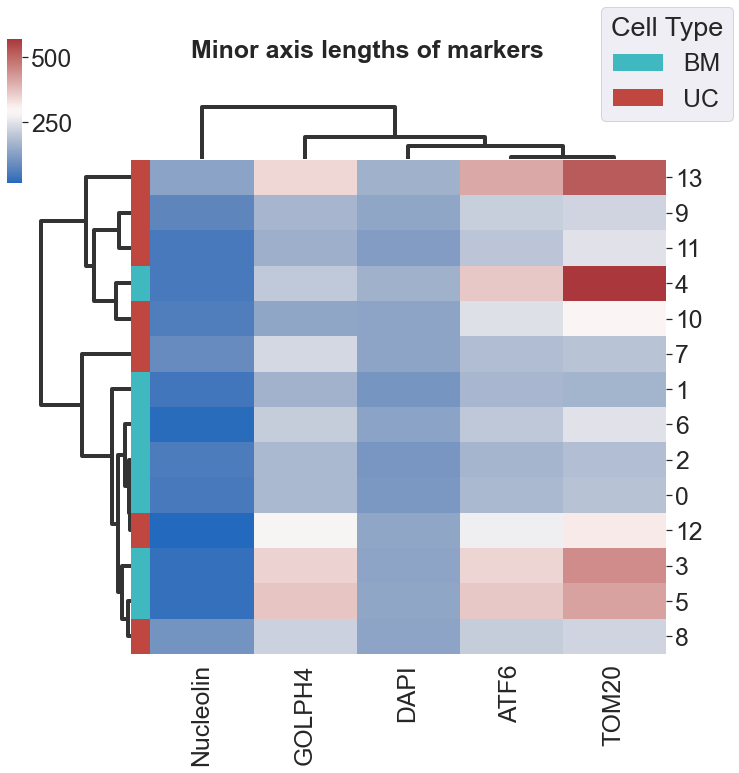

In [16]:
metric_list = [
    'correlation',
]

data_pivot = df2
data_pivot = data_pivot.loc[:, list_pair_modif]

lut1 = dict(zip(set(cell_type_label), sns.hls_palette(len(set(cell_type_label)), l=0.5, s=0.5)))
row_colors1 = pd.Series(cell_type_label).map(lut1)

for metric_temp in tqdm(metric_list):
    sns.set(font_scale = 2.25)
    g=sns.clustermap(data_pivot, 
                     figsize=(10, 10),
                     row_colors=[row_colors1], 
                     yticklabels=True, 
                     cbar_pos=(0, 0.85, 0.02, .2),  
                     metric=metric_temp,
                     dendrogram_ratio=(0.15, 0.1),
                    cmap='vlag', 
                    tree_kws=dict(linewidths=4))

    for label in np.unique(np.array(cell_type_label, dtype=object)):
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cell Type', loc="upper left", bbox_to_anchor=(0.85, 3))
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 

    g.fig.suptitle(f"Minor axis lengths of markers", x=0.5, y=1.05, fontsize=25, fontweight='bold')
    image_path_png = save_path+"/minor_axis_clustered_"+str(metric_temp)+".png"
    g.savefig(image_path_png, bbox_inches="tight")
    plt.show()

In [17]:
# format table for suppl
# BM
tbl = df2.set_index('Cell')
tbl.index.name = 'Marker Pair'
tbl = tbl.iloc[:7, :].transpose()
tbl.to_csv(os.path.join(save_path, 'minor_axis_BM.csv'))

# UC
tbl = df2.set_index('Cell')
tbl.index.name = 'Marker Pair'
tbl = tbl.iloc[7:, :].transpose()
tbl.to_csv(os.path.join(save_path, 'minor_axis_UC.csv'))


### Heatmap of major axis

In [18]:
# import data from CSV
featureSelect = 'AreaShape_MajorAxisLength'

os.chdir(data_cp)
csvFiles = [f for f in os.listdir() if f.endswith('.csv') \
           and 'Experiment' not in f and 'Image' not in f and 'UC' not in f]

df3 = pd.DataFrame(columns = ['Cell'])
for ii, fileName in enumerate(tqdm(csvFiles)): # each marker and cell type
    
    cellType, marker, _ = fileName.split('_')
    marker = marker.upper()
    dfMarker = pd.read_csv(fileName)
    
    cellLabel = cellType + dfMarker['ImageNumber'].astype(str)
    
    # reformat
    dfSub = pd.DataFrame()
    dfSub['Cell'] = cellLabel
    dfSub[marker] = dfMarker[featureSelect]
    # dfSub['Marker'] = marker
    # df = pd.concat([df, dfSub])
    
    # read UC file too
    fileName = fileName.replace('BM', 'UC')
    dfMarker = pd.read_csv(fileName)
    cellType, marker, _ = fileName.split('_')
    marker = marker.upper()
    cellLabel = cellType + dfMarker['ImageNumber'].astype(str)
    dfSub = pd.concat([dfSub, \
                       pd.DataFrame({'Cell': cellLabel, marker: dfMarker[featureSelect]})])
    
    df3 = df3.merge(dfSub, how = 'outer')
 
df3 = df3.drop_duplicates(subset = ['Cell']).reset_index(drop = True)

  0%|          | 0/11 [00:00<?, ?it/s]

In [19]:
# cells = cp.Cells.fromDir(data_cp)
# df3 = cells.getFeatureDataFrame(featurematchers="AreaShape_MajorAxisLength").sort_index()
df3 = df3.rename(columns={"BT": "BetaTubulin", "CONA": "ConcanavalinA", "G4": "GOLPH4", "NUC": "Nucleolin", "PH": "Phalloidin", "SOR": "Sortilin", "T20": "TOM20"})
df3

,Cell,ATF6,BetaTubulin,ConcanavalinA,DAPI,GOLPH4,HSP60,Nucleolin,Phalloidin,Sortilin,TOM20,WGA
0,BM1,636.765460,786.365018,640.944890,208.987960,622.367933,770.533294,62.278344,778.681968,597.713649,684.360466,636.042676
1,BM2,468.725847,439.982856,506.473750,195.661793,419.111478,413.768492,54.538642,466.739903,365.053523,426.752664,372.983560
2,BM3,204.998808,211.327038,223.278330,121.244202,223.932373,268.356565,82.918703,246.710868,210.772380,201.951252,223.656584
3,BM4,561.160182,730.361380,761.488781,200.281450,517.104048,595.572531,45.920981,930.703008,557.171413,699.615231,592.626591
4,BM5,452.470935,584.370815,528.198999,204.995628,396.704931,522.405135,84.069888,648.229071,423.538598,720.062552,494.121251
5,BM6,615.572579,814.977056,820.954754,197.937579,657.577717,1021.358253,38.137174,1033.739597,888.562427,777.219930,987.441143
6,BM7,541.135701,978.948908,720.299098,229.064981,597.289289,905.551862,74.498290,1100.639470,445.486111,882.112154,626.131632
7,UC1,706.871634,1250.359322,788.996826,239.541978,725.687449,1671.145267,167.382289,949.258796,990.554406,858.918854,870.179057
8,UC2,411.924128,838.917873,526.441181,218.476548,499.676368,854.777346,154.584817,451.442004,505.190225,482.375643,483.497188
9,UC3,421.994210,809.903496,588.508857,224.920858,590.885594,775.682550,96.803088,498.972949,397.589438,649.787916,483.858310


  0%|          | 0/1 [00:00<?, ?it/s]

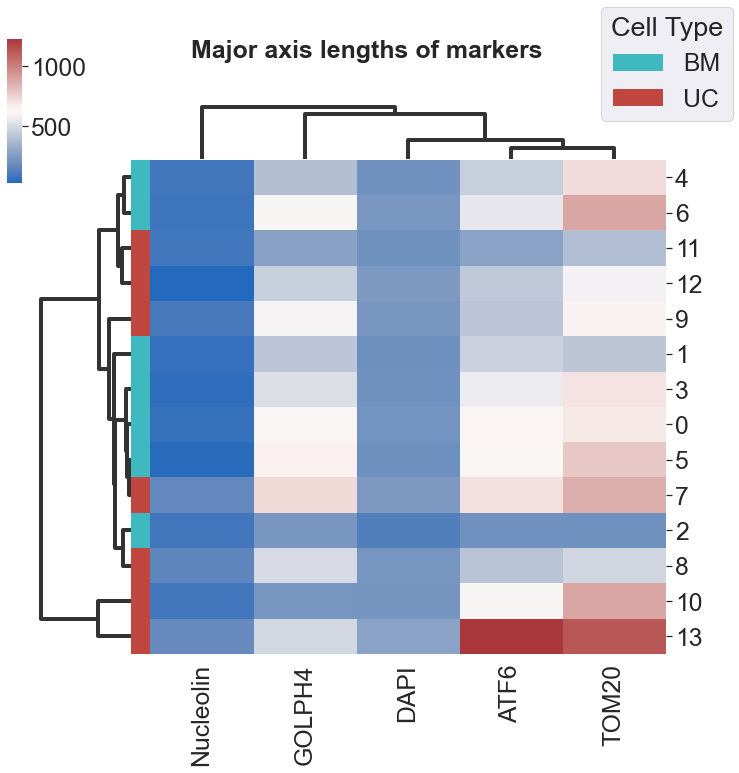

In [20]:
metric_list = [
    'correlation',
]

data_pivot = df3
data_pivot = data_pivot.loc[:, list_pair_modif]

lut1 = dict(zip(set(cell_type_label), sns.hls_palette(len(set(cell_type_label)), l=0.5, s=0.5)))
row_colors1 = pd.Series(cell_type_label).map(lut1)

for metric_temp in tqdm(metric_list):
    sns.set(font_scale = 2.25)
    g=sns.clustermap(data_pivot, 
                     figsize=(10, 10),
                     row_colors=[row_colors1], 
                     yticklabels=True, 
                     cbar_pos=(0, 0.85, 0.02, .2),  
                     metric=metric_temp,
                     dendrogram_ratio=(0.15, 0.1),
                    cmap='vlag', 
                    tree_kws=dict(linewidths=4))

    for label in np.unique(np.array(cell_type_label, dtype=object)):
        g.ax_col_dendrogram.bar(0, 0, color=lut1[label], label=label, linewidth=0)
    l1 = g.ax_col_dendrogram.legend(title='Cell Type', loc="upper left", bbox_to_anchor=(0.85, 3))
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0) 


    g.fig.suptitle(f"Major axis lengths of markers", x=0.5, y=1.05, fontsize=25, fontweight='bold')
    image_path_png = save_path+"/major_axis_clustered_"+str(metric_temp)+".png"
    g.savefig(image_path_png, bbox_inches="tight")
    plt.show()

In [21]:
# format table for suppl
# BM
tbl = df3.set_index('Cell')
tbl.index.name = 'Marker Pair'
tbl = tbl.iloc[:7, :].transpose()
tbl.to_csv(os.path.join(save_path, 'major_axis_BM.csv'))

# UC
tbl = df3.set_index('Cell')
tbl.index.name = 'Marker Pair'
tbl = tbl.iloc[7:, :].transpose()
tbl.to_csv(os.path.join(save_path, 'major_axis_UC.csv'))
